In [1]:
# create whittaker biome remapping
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm

/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
import geopandas as gpd
from shapely.geometry import *

In [19]:
sys.path.append('../')
from utils.pyfunctions import *

In [22]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41985 instead
  f"Port {expected} is already in use.\n"


In [40]:
def byhand(t,p):
    t1 = -5  #    tundra-boreal
    t2 =  3  #    boreal-temperate
    t3 = 20  # temperate-tropical

    tvals = [-np.inf,t1,t2,t3,np.inf]
    bvals = [9,8,4,1]


    for i in range(4):
        if (t>tvals[i])&(t<=tvals[i+1]):
            b = bvals[i]

    td = 15; pd=60; bd=3  #desert
    if (t>td)&(p<pd):
        b = bd

    return b

In [27]:
def asum(da):
    #annual sum of monthly data
    m  = da['time.daysinmonth']
    xa = (m*da).groupby('time.year').sum().compute()
    return xa

In [3]:
fp = '../utils/whit/Whittaker_biomes.shp'
data = gpd.read_file(fp)
og   = data.biome_id.copy(deep=True).values

In [4]:
newb = np.array([9,8,7,6,5,4,1,2,3])
data.biome_id=newb #more logical order

In [32]:
df = pd.read_csv('../utils/whit/Whittaker_biomes.csv')
x  = df.biome_id.values 

In [31]:
for i in 1+np.arange(9):
    ix = data.biome_id==i
    b  = newb[og==i]
    x[ix]=b
df.biome_id=x

IndexError: boolean index did not match indexed array along dimension 0; dimension is 775 but corresponding boolean dimension is 9

In [33]:
# fetch the sparsegrid landarea
la_file = '../utils/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

In [23]:
# load ensemble
yy = (1986,2015)
dir='/glade/campaign/cgd/tss/projects/PPE/ctsm530_OAAT/hist/'
key = '../clm6_minioaat.csv'
exp='oaat'
tape='h0'
utils_path = '/glade/u/home/linnia/CLM6-PPE/clm6-oaat/utils/'

dvs=['GPP','TBOT','RAIN','SNOW']
ds= get_exp(exp,dir,key,dvs,'h0',yy,utils_path)

In [73]:
default= ds.isel(ens=101) #.sel(time=slice("2006-01-01", "2015-12-31"))

In [74]:
tbot = amean(default.TBOT).mean(dim='year').compute()-273.15  #degC
gpp  = 24*60*60*asum(default.GPP).mean(dim='year').compute() #gC/m2/yr
rain = 24*60*60/10*asum(default.RAIN).mean(dim='year').compute()  #cm/yr
snow = 24*60*60/10*asum(default.SNOW).mean(dim='year').compute()  #cm/yr
prec = rain+snow

In [75]:
bclass = np.zeros(400)+np.nan
for i in range(400):
    if (tbot[i]<0)&(gpp[i]==0):
        bclass[i]=0  #ice
    else:
        ptf = gpd.GeoDataFrame({'geometry':[Point(tbot[i],prec[i])]})
        x=gpd.overlay(ptf, data, how='intersection')
        if len(x)>0:
            bclass[i] = x.biome_id.values
        else:
            bclass[i] = byhand(tbot[i],prec[i])


In [76]:
c = np.zeros([10,3])
c[1,:] = [9,91,31]
c[2,:] = [171,215,102]
c[3,:] = [218,203,111]
c[4,:] = [29,196,130]
c[5,:] = [136,246,72]
c[6,:] = [205,108,60]
c[7,:] = [245,245,159]
c[8,:] = [91,56,9]
c[9,:] = [160,211,216]
c = c/256

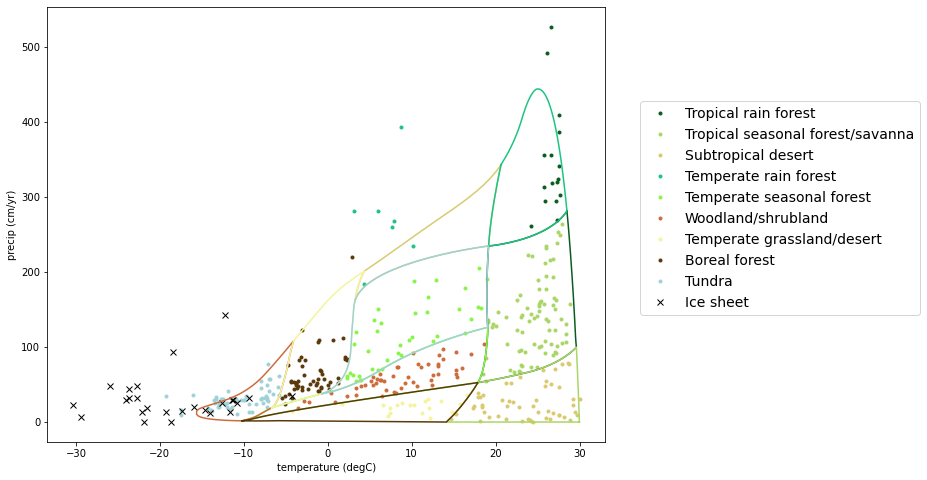

In [77]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
biomes = np.unique(df.biome_id.values)
ll=[]
for i in 1+np.arange(9):
    ix = bclass==i
    plt.plot(tbot[ix],prec[ix],'.',color=c[i,:])
    ll.append(data.biome[data.biome_id==i].values[0])

ix = bclass==0
plt.plot(tbot[ix],prec[ix],'kx')
ll.append('Ice sheet')

    
plt.legend(ll,bbox_to_anchor = (1.05, 0.8),fontsize=14)
for i in 1+np.arange(9):
    ix = df.biome_id==i
    t = df.temp_c[ix]
    p = df.precp_cm[ix]
    plt.plot(t,p,'-',color=c[i,:])

plt.xlabel('temperature (degC)')
plt.ylabel('precip (cm/yr)');


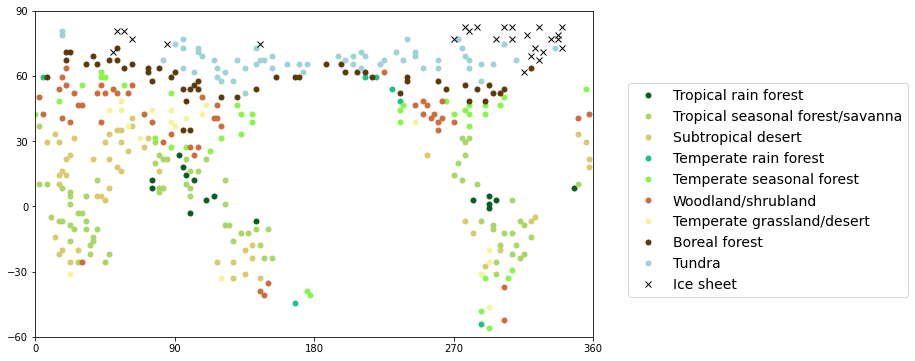

In [78]:
fig = plt.figure(figsize=[10,6])
ll = []
for i in 1+np.arange(9):
    ix = bclass==i
    plt.plot(ds.grid1d_lon[ix],ds.grid1d_lat[ix],'.',color=c[i,:],markersize=10)
    ix = data.biome_id==i
    ll.append(data.biome[ix].values[0])
ix = bclass==0
plt.plot(ds.grid1d_lon[ix],ds.grid1d_lat[ix],'kx')
ll.append('Ice sheet')
plt.legend(ll,bbox_to_anchor = (1.05, 0.8),fontsize=14)
plt.ylim([-60,90])
plt.xlim([0,360])
plt.yticks(-60+30*np.arange(6))
plt.xticks(90*np.arange(5));

### Write

In [79]:
ds_out = xr.Dataset()
da = xr.DataArray(bclass,coords={'gridcell':ds.gridcell})
ds_out['biome']=da
for v in ['grid1d_lat','grid1d_lon']:
    ds_out[v]=ds[v]

In [80]:
b_ids  = 1+np.arange(9)
bnames = [data.biome[data.biome_id==i].values[0] for i in b_ids]
b_ids  = [0,*b_ids]
bnames = ['Ice sheet',*bnames]
da = xr.DataArray(bnames,coords={'biome_id':b_ids})
ds_out['biome_name']=da

In [81]:
ds_out.to_netcdf('../utils/whit/whitkey_CRUJRA.nc')

In [82]:
sgmap=xr.open_dataset('../utils/sgmap_retrain_h0.nc')
bmap = get_map(ds_out.biome,sgmap)

In [90]:
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(c, name="custom_cmap")  # Skip the first row, which is [0,0,0]


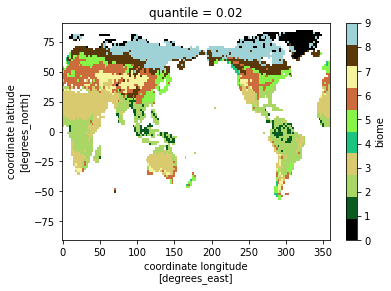

In [91]:
bmap.plot(cmap = cmap)